# EELS SrFeO Project 
## Data Preparation
> **PCA and t-SNE are also attempted in this notebook**

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*

September 2019:
> The data provided includes initial state (SrFeO3 with Fe4+) and annealed state (SrFeO2.5 with Fe3+). Total of 90,000 spectra was provided: 
- 2 sets of 10 spectrum images with 300 x 30 spatial coordinates. 
- Each spatial coordinate has 3710 energy channels. 
- For each spectra, the initial energy-loss value is 387.5 eV with energy width of 0.125 eV.
- i.e. \[387.5: 851.25: 0.125\]


### Import Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
import pandas as pd
import scipy
import itertools
hs.preferences.GUIs.warn_if_guis_are_missing = False

### Loading Data

Avoid stacking because you will lose access to multi-files metadata

In [88]:
# Loading Data

raw_data = hs.load('temporal_data/EELS Spectrum ImageFrames/EELS*.dm4', stack=False)

In [89]:
#print(raw_data[0].metadata)
#print(raw_data[0].axes_manager)

In [90]:
raw_data[0].data.shape

(36, 114, 3710)

### Dark reference
Software used to collect EELS data has some glitches. Dark reference is provided and must be added to each spectrum.

In [91]:
def add_dark_ref(stacked_data, dark_ref):
    """
    Add dark references to EELS dataset
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    dark_ref: 1d array
        dark reference for correction
    """
    dim = stacked_data[0].data.shape
    for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
        stacked_data[k].data[i,j] = np.sum([stacked_data[k].data[i,j],dark_ref.data], axis=0)

In [92]:
# Add dark references

dark_ref = hs.load('temporal_data/EELS Spectrum ImageFrames/bkg.dm4')
add_dark_ref(raw_data, dark_ref)

### Background Subtraction 

Jamie suggested performing background subtraction based on power law fit. $I = A*E^r$
* I is the measured intensity, 
* A is a constant
* E is the energy-loss value (eV)
* r is an exponent (usually around 3)

Select an energy window (around 50 eV wide) at around a few eV before the region of interest to fit A and r.

#### Resources
https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes \
https://scipy-cookbook.readthedocs.io/items/FittingData.html \
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [102]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)
'''
import scipy.optimize # curve_fit
from scipy.fftpack import fft

def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = range(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = x 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4.19082741e+02, -1.93625569e-03])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            # print(popt)
    return data2

def subtract_bckgrnd_and_filter(data):
    backgroundregion = np.arange(100,500,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].data = subtractExpBackground(spectra.data,backgroundregion)
        #data[k].data = scipy.signal.savgol_filter(data[k].data, 51, 3) # window size 50, polynomial order 3
        print("Progress: "+str(k+2)+"/"+str(len(data)), end="\r")

In [103]:
subtract_bckgrnd_and_filter(raw_data)

### Savitzky–Golay Noise Filter

In [104]:
def filter_savgol(stacked_data):
    """
    Apply Savitzky–Golay filter to reduce noise
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    """
    for k,spectra in enumerate(stacked_data):
        # Savitzky–Golay filter with window size 51, polynomial order 3
        stacked_data[k].data = scipy.signal.savgol_filter(stacked_data[k].data, 51, 3) 

In [105]:
# Apply SavGol filter

filter_savgol(raw_data)

### Cropping spectral image

(17, 114)


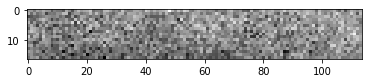

In [106]:
# Visualizing cropped area
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

cropped = np.average(raw_data[3].data[8:25], axis=(2))
print(cropped.shape)

fig, ax = plt.subplots()
im = ax.imshow(cropped)

In [107]:
# window is y = [7:35]
def crop(data):
    for k,sp in enumerate(data):
        data[k].data = sp.data[8:25]
        print(str(k)+": "+str(data[k].data.shape))

In [108]:
crop(raw_data)

0: (17, 114, 3710)
1: (17, 114, 3710)
2: (17, 114, 3710)
3: (17, 114, 3710)
4: (17, 114, 3710)
5: (17, 114, 3710)
6: (17, 114, 3710)
7: (17, 114, 3710)
8: (17, 114, 3710)
9: (17, 114, 3710)
10: (17, 114, 3710)
11: (17, 114, 3710)
12: (17, 114, 3710)
13: (17, 114, 3710)
14: (17, 114, 3710)
15: (17, 114, 3710)
16: (17, 114, 3710)
17: (17, 114, 3710)
18: (17, 114, 3710)
19: (17, 114, 3710)
20: (17, 114, 3710)
21: (17, 114, 3710)
22: (17, 114, 3710)
23: (17, 114, 3710)
24: (17, 114, 3710)
25: (17, 114, 3710)
26: (17, 114, 3710)
27: (17, 114, 3710)
28: (17, 114, 3710)
29: (17, 114, 3710)
30: (17, 114, 3710)
31: (17, 114, 3710)
32: (17, 114, 3710)
33: (17, 114, 3710)
34: (17, 114, 3710)
35: (17, 114, 3710)
36: (17, 114, 3710)
37: (17, 114, 3710)
38: (17, 114, 3710)
39: (17, 114, 3710)
40: (17, 114, 3710)
41: (17, 114, 3710)
42: (17, 114, 3710)
43: (17, 114, 3710)
44: (17, 114, 3710)
45: (17, 114, 3710)
46: (17, 114, 3710)
47: (17, 114, 3710)
48: (17, 114, 3710)
49: (17, 114, 3710)


### Downsampling

Done to reduce data size.

#### Resources
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [109]:
from scipy.signal import resample

def downsample(stacked_data, N_resampled:int):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].data.shape
    if N_resampled != dim[2]: 
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled) 
    else:
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], dim[2]))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = stacked_data[k].data[i][j][:]

In [110]:
raw_data[0].data.shape

(17, 114, 3710)

In [111]:
N_resampled = 1500
#N_resampled = raw_data[0].data.shape[2]
downsample(raw_data, N_resampled)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

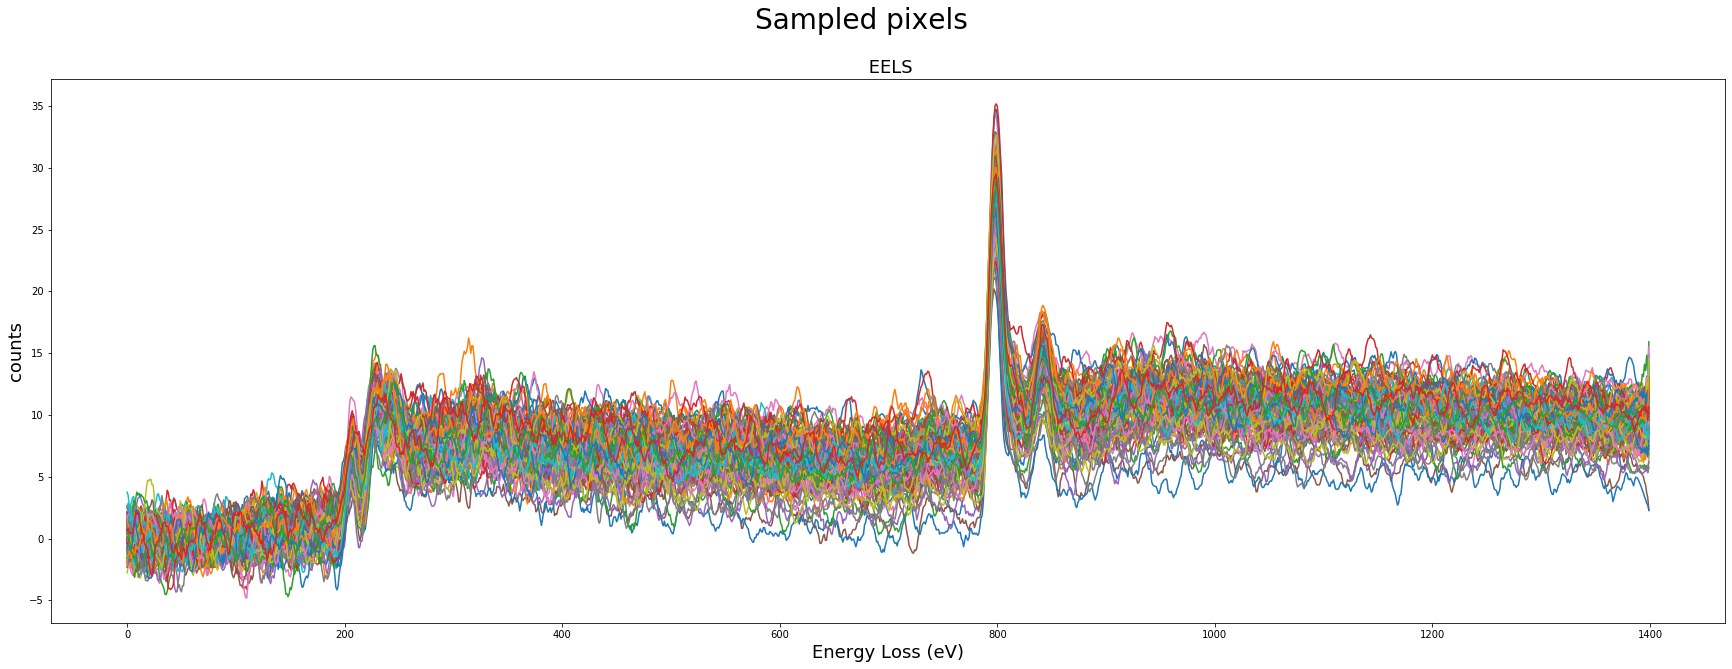

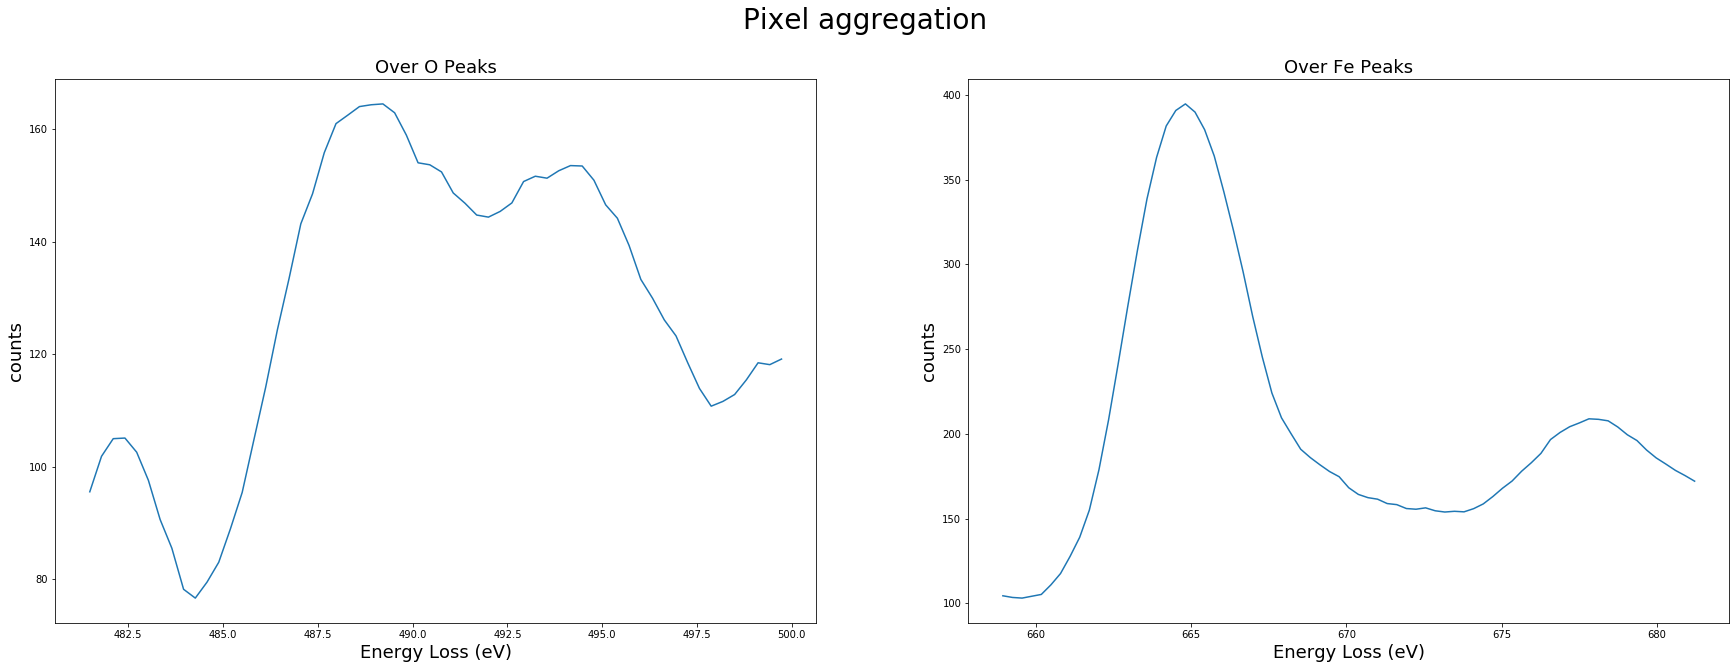

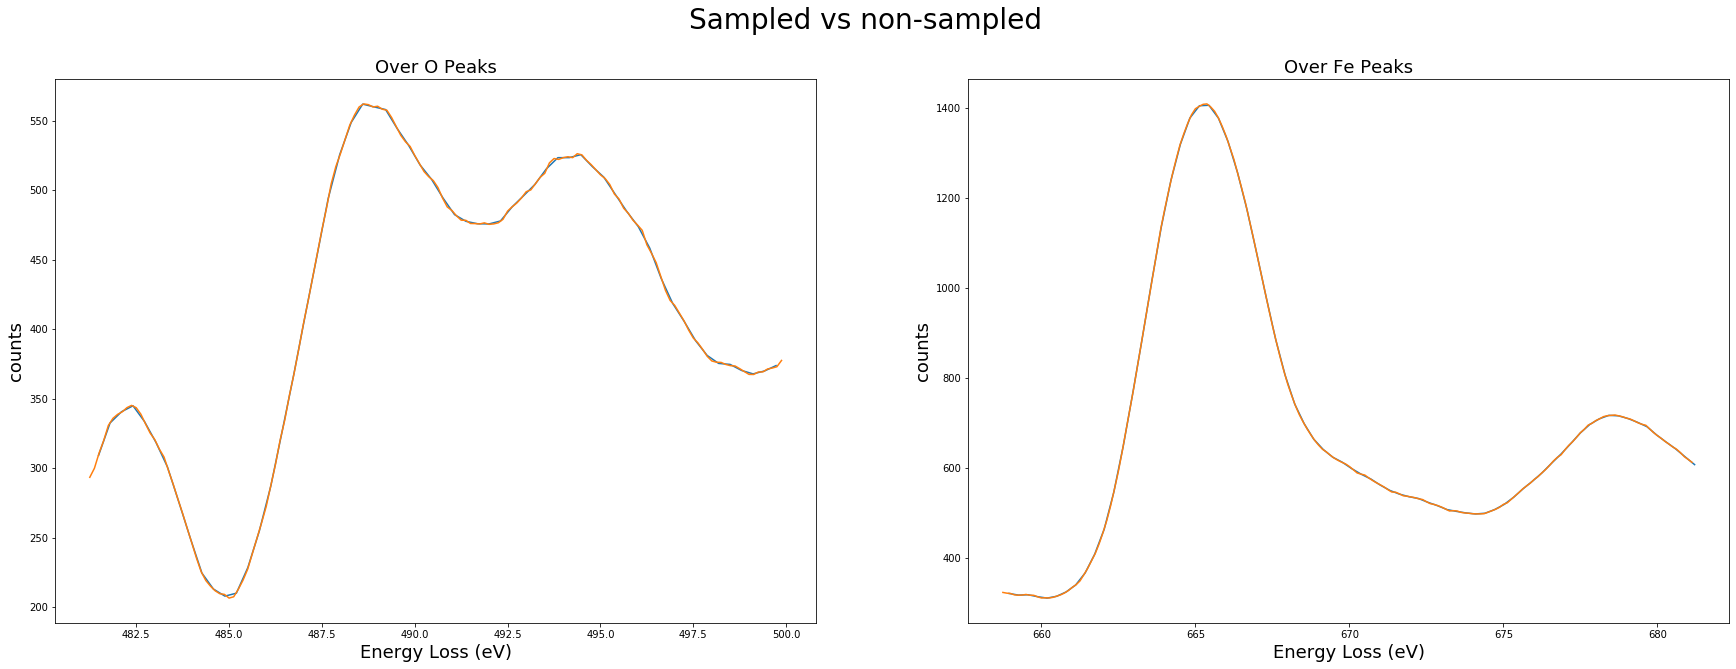

In [113]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV
o_r = (750,900)
fe_r = (2170,2350)


frac = N_resampled/raw_data[0].data.shape[2]
O_range = range(math.ceil(o_r[0]*frac),math.ceil(o_r[1]*frac),1)
Fe_range = range(math.ceil(fe_r[0]*frac),math.ceil(fe_r[1]*frac),1)
O_xrange = [start+step*i/frac for i in O_range]
Fe_xrange = [start+step*i/frac for i in Fe_range]

# Plotting individual spectrum
f,(ax1) = plt.subplots(1,1, figsize=(30,10))
# raw data on image 3, [20,:,400:2500]
for i in raw_data[3].resample[15]:
    ax1.plot(i[100:3000])

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
# Plotting aggregation over oxygen range
ax3.plot(O_xrange, np.sum(raw_data[10].resample[15][100:200], axis=0)[O_range])
# Plotting aggregation over Fe range
ax4.plot(Fe_xrange, np.sum(raw_data[10].resample[15][100:200], axis=0)[Fe_range])

# Plotting aggregared spectra (sampled vs non-sampled)
h,(ax5,ax6) = plt.subplots(1,2, figsize=(30,10))
# Plotting aggregation over oxygen range
ax5.plot(O_xrange, np.sum(raw_data[3].resample[15][50:100], axis=0)[O_range])
ax5.plot([start+(i*step) for i in range(o_r[0],o_r[1],1)], np.sum(raw_data[3].data[15][50:100], axis=0)[o_r[0]:o_r[1]])
# Plotting aggregation over Fe range
ax6.plot(Fe_xrange, np.sum(raw_data[3].resample[15][50:100], axis=0)[Fe_range])
ax6.plot([start+(i*step) for i in range(fe_r[0],fe_r[1],1)], np.sum(raw_data[3].data[15][50:100], axis=0)[fe_r[0]:fe_r[1]])

# plot configurations
f.suptitle('Sampled pixels', fontsize=28)

ax1.set_title(' EELS', fontsize=18)
ax1.set_xlabel('Energy Loss (eV)', fontsize=18)
ax1.set_ylabel('counts', fontsize=18)

g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)   

h.suptitle('Sampled vs non-sampled', fontsize=28)
ax5.set_title('Over O Peaks', fontsize=18)
ax5.set_xlabel('Energy Loss (eV)', fontsize=18)
ax5.set_ylabel('counts', fontsize=18)   

ax6.set_title('Over Fe Peaks', fontsize=18)
ax6.set_xlabel('Energy Loss (eV)', fontsize=18)
ax6.set_ylabel('counts', fontsize=18)   

### Normalizing data

Normalizing data over the 2 regions of interest

resource: https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes/__init__.py

In [115]:
def normalize(data, data_normal=None,extra_output=None):
    """
    Normalizes the data
    
    Parameters
    ----------
    data : numpy, array
        data to normalize
    data_normal : numpy, (optional)
        data set to normalize with
        
    Returns
    -------
    data_norm : numpy, array
        Output of normalized data
    """

    if data_normal is None:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_norm.reshape(-1)))
        data_norm -= mean
        std = np.std(data_norm)
        data_norm /= std
    else:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_normal.reshape(-1)))
        data_norm -= mean
        std = np.std(data_normal)
        data_norm /= std
    if extra_output==None:
        return data_norm
    else:
        return data_norm, std, mean

In [116]:
for k,spectra in enumerate(raw_data):
    raw_data[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)

### Section out region of interest (ROI)

Here is from the manual observation of the data from the previous aggregate plot:
- analysis_range = 400 raw data points
- O_range = starts @ 700 [700:1000]
- Fe_range = starts @ 2100 [2100:2400]

In [117]:
def cut_ROI(data, N_resampled):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]
    
    o_range = (790,870)
    fe_range = (2170,2350)
    anly_o_range = o_range[1] - o_range[0]
    anly_fe_range = fe_range[1] - fe_range[0]
    
    oc0 = math.ceil(o_range[0]/N_0*N_resampled)
    oc1 = math.ceil(o_range[1]/N_0*N_resampled)
    fc0 = math.ceil(fe_range[0]/N_0*N_resampled)
    fc1 = math.ceil(fe_range[1]/N_0*N_resampled)

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.data_norm.shape[0], spectra.data_norm.shape[1], oc1-oc0))
        data[k].Fe_range = np.zeros((spectra.data_norm.shape[0], spectra.data_norm.shape[1], fc1-fc0))
        #print(math.ceil((o_range[1]+anly_o_range)/N_0*N_resampled))
        for i in range(spectra.data_norm.shape[0]):
            for j in range(spectra.data_norm.shape[1]):
                data[k].O_range[i][j] = spectra.data_norm[i][j][oc0:oc1]
                data[k].Fe_range[i][j] = spectra.data_norm[i][j][fc0:fc1]

In [118]:
cut_ROI(raw_data, N_resampled)

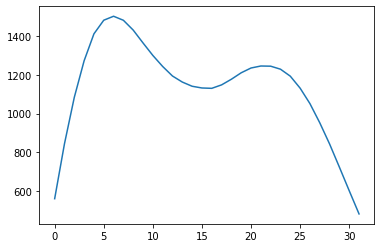

In [119]:
plt.plot(np.sum(raw_data[0].O_range, axis=(0,1)))

## Conclusion

Steps taken in this notebook:
- Dark reference
- Power law fit
- Savgol filter
- Downsampling
- Normalization
- Cutting ROI

### Saving data object 

Saving object to file for future use.

In [68]:
# Saving object to hyperspy format

#TODO: There is still a problem that target and resample data not saved in .hdf5 file
import pickle 
class Container(object): pass
stack = []

for k,f in enumerate(raw_data):
    data_container = Container()
    data_container.O_range = f.O_range
    data_container.Fe_range = f.Fe_range
    data_container.data = f.data
    data_container.metadata = f.metadata
    stack.append(data_container)

for k,f in enumerate(stack):
    filehandler = open("processed_data/EELS_o_range_"+str(k)+".pkl", 'wb') 
    pickle.dump(f, filehandler)
    print("Save "+str(k+1)+"/"+str(len(raw_data)), end='\r')
    #if k == 5: break

In [69]:
# test = pickle.load(open("processed_data/EELS_o_range_0.pkl", 'rb'))

## Principle Component Analysis
- Perform PCA on the 2 regions 
- reconstructing eigen components into 30x300 image & deconstruct again using PCA 

Essentially, I'm trying to use varience to explain my data. 

### Testing out PCA

In [121]:
from sklearn.decomposition import PCA

In [122]:
#print(data_target.shape)
print(raw_data[0].O_range.shape)

(17, 114, 32)


In [123]:
data_ana = raw_data[0].O_range.reshape((-1,raw_data[0].O_range.shape[2]))
#data_tar = data_target.reshape((-1))

In [124]:
pca = PCA(16)  # project from N_resampled to 2 dimensions
projected = pca.fit_transform(data_ana)
print(data_ana.shape)
print(projected.shape)

(1938, 32)
(1938, 16)


Text(0, 0.5, 'cumulative explained variance')

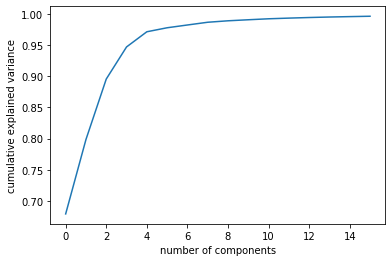

In [125]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

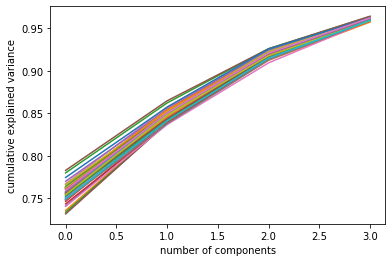

In [82]:
import sklearn
numPCAcomp=4
container = list()
for k in range(len(raw_data)):
    arrayx = np.array(raw_data[k].O_range[5:22])
    sha = arrayx.shape
    pca = sklearn.decomposition.PCA(n_components=numPCAcomp)
    PCA = pca.fit(arrayx.reshape((-1,sha[2])))
    PCAembeddings = PCA.transform(arrayx.reshape((-1,sha[2])))[:, 0:numPCAcomp].reshape((sha[0],sha[1],-1))
    container.append(PCAembeddings)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

In [83]:
container[0].shape

(17, 114, 4)

## Plot PCA map

fig size: 72.0 DPI, size in inches [12.  6.]


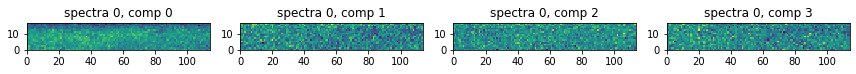

In [85]:
import sys
from matplotlib.animation import FuncAnimation
ax=[]
fig, (ax) = plt.subplots(1,numPCAcomp, figsize=(12,6))
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(k):
    label = 'timestep {0}'.format(k)
    print(label, end='\r')
    for i in range(numPCAcomp):
        pcolor = ax[i].pcolor(container[k][:,:,i], cmap='viridis')
        ax[i].axis('scaled')
        #ax[i].invert_yaxis()
        #pcolor.set_clim(0, 2)
        #fig.colorbar(pcolor)
        ax[i].set_title("spectra "+str(k)+", comp "+str(i))
    return ax

#if __name__ == '__main__':
# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, len(container)), interval=200)
#if len(sys.argv) > 1 and sys.argv[1] == 'save':
anim.save('PCA_temporal.gif', dpi=80, writer='imagemagick')
#else:
    # plt.show() will just loop the animation forever.
#    plt.show()